# Practice Implementation 

In [4]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv('daily_csv.csv')
df = df.dropna()
prices = df['Price'].values
minn, maxx = prices.min(), prices.max()
prices = (prices - minn) / (maxx - minn)
X, y = [], []
sequence_length = 10
for i in range(5900):
    l = []
    for j in range(i, i + sequence_length):
        l.append(prices[j])
    X.append(l)
    y.append(prices[i + sequence_length])
X, y = np.array(X), np.array(y)

### Memorize Train Test Split ###

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size= 0.10, random_state= 42, stratify= None)

In [7]:
class Data(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x, dtype= torch.float32)
        self.y = torch.tensor(y, dtype= torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [8]:
train = Data(xtrain, ytrain)
test = Data(xtest, ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size= 256, shuffle= True, drop_last= True)
test_loader = torch.utils.data.DataLoader(test, batch_size= 256, drop_last= True)

### LSTM Model ###

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers,
                          dropout=dropout, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # use the last time step
        out = self.fc(out)
        return out

In [10]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size= 1, hidden_size= 5, batch_first= True, num_layers= 1)
        self.fc1 = torch.nn.Linear(in_features= 5, out_features= 1)
    def forward(self, x):
        y, h = self.lstm(x)
        y = y[:, -1, :]
        return self.fc1(torch.relu(y))

In [11]:
model = Network()
model = model.to('cpu')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001, weight_decay= 0.0001)

### Model Training ###

In [14]:
model.train()
patience = 100  # how many epochs to wait before stopping
best_loss = float('inf')
counter = 0

for epoch in range(1500):
    running_loss = 0.0
    for input, target in train_loader:
        optimizer.zero_grad()
        input, target = input.reshape((-1, sequence_length, 1)).to('cpu'), target.to('cpu')
        output = model(input).reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Optionally, calculate validation loss here
    val_loss = running_loss  # replace with actual val_loss if you have val_loader

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {running_loss:.4f}')


Epoch 0, Loss: 0.0054
Epoch 50, Loss: 0.0059
Epoch 100, Loss: 0.0058
Epoch 150, Loss: 0.0057
Early stopping at epoch 151


### Model Evaluation ###

In [15]:
model.eval()
all_pred, all_label = [], []
with torch.no_grad():
    for input, target in test_loader:
        input, target = input.reshape((-1, sequence_length, 1)).to('cpu'), target.to('cpu')
        output = model(input).reshape(-1)
        all_pred.extend(output.to('cpu').detach().numpy())
        all_label.extend(target.to('cpu').detach().numpy())

In [16]:
print(mean_squared_error(all_pred, all_label))

0.00017325962334865925


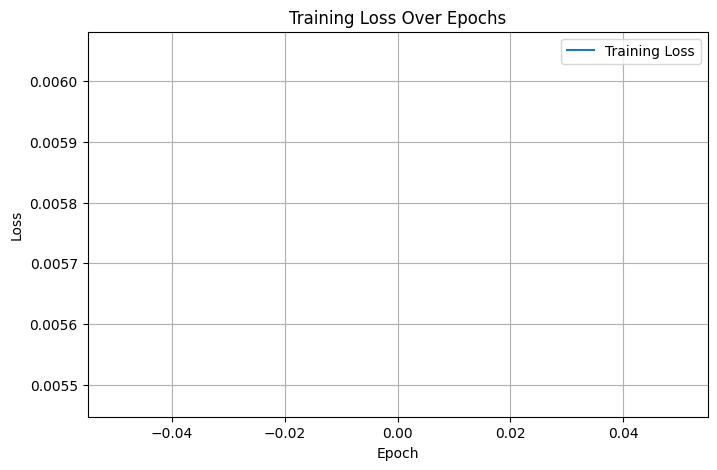

In [17]:
# Plot 1: Training Loss
plt.figure(figsize=(8, 5))
plt.plot(running_loss, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
